In [1]:
#!wget -q https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip
#!wget -q https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip
#!unzip -qq Flickr8k_Dataset.zip
#!unzip -qq Flickr8k_text.zip
#!rm Flickr8k_Dataset.zip Flickr8k_text.zip

In [2]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import efficientnet
from tensorflow.keras.layers import TextVectorization

In [3]:
# Path to the images
IMAGES_PATH = "Flicker8k_Dataset"

# Desired image dimensions
IMAGE_SIZE = (299, 299)

# Vocabulary size
VOCAB_SIZE = 10000

# Fixed length allowed for any sequence
SEQ_LENGTH = 25

# Dimension for the image embeddings and token embeddings
EMBED_DIM = 256

# Per-layer units in the feed-forward network
FF_DIM = 128

# Other training parameters
BATCH_SIZE = 64
EPOCHS = 30
AUTOTUNE = tf.data.AUTOTUNE

##Preparing the dataset

In [4]:
def load_captions_data(filename):
    """Loads captions (text) data and maps them to corresponding images.

    Args:
        filename: Path to the text file containing caption data.

    Returns:
        caption_mapping: Dictionary mapping image names and the corresponding captions
        text_data: List containing all the available captions
    """
    df = pd.read_csv(filename, sep=',')
    caption_mapping = {}
    text_data = []
    images_to_skip = set()

    for index, row in df.iterrows():
      # each image is repeated 5 times
      img_name, caption = row
      img_name = os.path.join(IMAGES_PATH, img_name.strip())

      tokens = caption.strip().split()

      #Remove image with too short or too long caption
      if len(tokens)<5 or len(tokens)>SEQ_LENGTH:
        images_to_skip.add(img_name)
        continue

      if img_name.endswith("jpg") and img_name not in images_to_skip:
        # adding a start and an end token to each caption
        caption = "<start> " + caption.strip() + " <end>"
        text_data.append(caption)

        if img_name in caption_mapping:
          caption_mapping[img_name].append(caption)
        else:
          caption_mapping[img_name] = [caption]

    for img_name in images_to_skip:
      if img_name in caption_mapping:
        del caption_mapping[img_name]

    return caption_mapping, text_data

captions_mapping, text_data = load_captions_data("captions.txt")

In [5]:
def train_val_split(caption_data, train_size=0.8, shuffle=True):
    """Split the captioning dataset into train and validation sets.

    Args:
        caption_data (dict): Dictionary containing the mapped caption data
        train_size (float): Fraction of all the full dataset to use as training data
        shuffle (bool): Whether to shuffle the dataset before splitting

    Returns:
        Traning and validation datasets as two separated dicts
    """

    all_img = list(caption_data.keys())

    if shuffle:
      np.random.shuffle(all_img)

    train_size = int(len(caption_data) * train_size)

    train_data = {
        img_name: captions_mapping[img_name] for img_name in all_img[:train_size]
        }

    val_data = {
        img_name: captions_mapping[img_name] for img_name in all_img[train_size:]
        }

    return train_data, val_data


train_data, valid_data = train_val_split(captions_mapping)
print("Number of training samples: ", len(train_data))
print("Number of validation samples: ", len(valid_data))

Number of training samples:  6114
Number of validation samples:  1529


##Vectorizing the text data

In [6]:
def custom_standardization(input_string):
  """
  Remove all strip chars from input_string
  """
  lowercase = tf.strings.lower(input_string)
  return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")

strip_chars = "!\"#$%&'()*+,-./:;=?@[\]^_`{|}~"

vectorization = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode="int",
    output_sequence_length=SEQ_LENGTH,
    standardize=custom_standardization,
)
vectorization.adapt(text_data)

##Building a tf.data.Dataset pipeline for training

In [7]:
def decode_and_resize(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMAGE_SIZE)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return img


def process_input(img_path, captions):
    return decode_and_resize(img_path), vectorization(captions)

def make_dataset(images, captions):
    dataset = tf.data.Dataset.from_tensor_slices((images, captions))
    dataset = dataset.shuffle(BATCH_SIZE * 8)
    dataset = dataset.map(process_input, num_parallel_calls=AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)

    return dataset


train_dataset = make_dataset(list(train_data.keys()), list(train_data.values()))
valid_dataset = make_dataset(list(valid_data.keys()), list(valid_data.values()))

##Data visualization

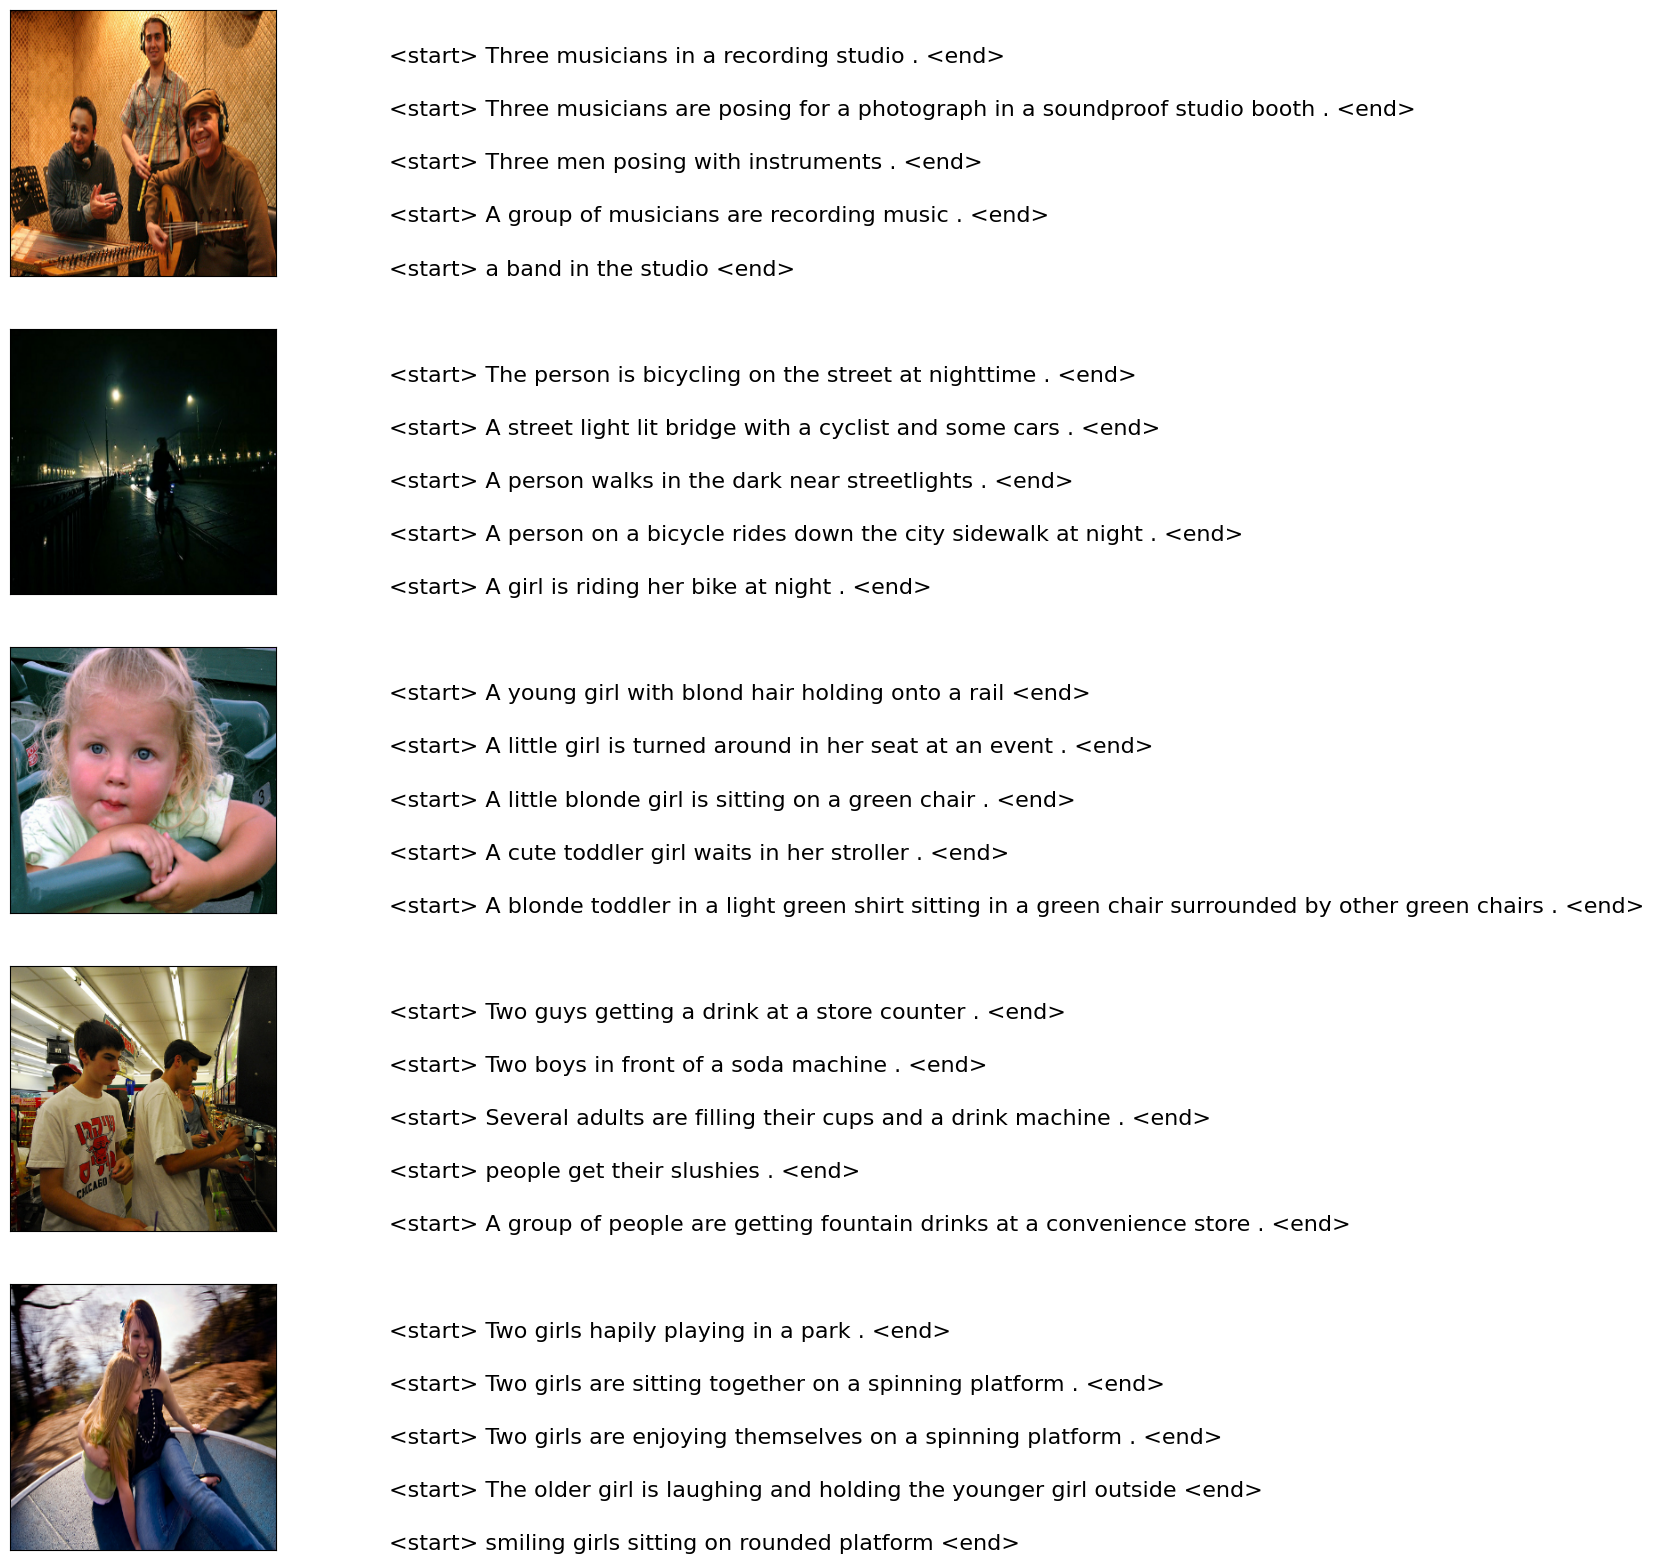

In [35]:
npic=5
count = 1
fig = plt.figure(figsize=(10,20))
all_images = list(captions_mapping.keys())

for i in range(npic):
    sample_img = np.random.choice(all_images)
    captions = captions_mapping[sample_img]

    sample_img = decode_and_resize(sample_img)
    img = sample_img.numpy().clip(0, 255).astype(np.uint8)

    ax = fig.add_subplot(npic, 2, count, xticks=[], yticks=[])
    ax.imshow(img)
    count += 1

    ax = fig.add_subplot(npic, 2 , count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0,1)
    ax.set_ylim(0, len(captions))
    for i, caption in enumerate(captions):
        ax.text(0, i, caption, fontsize=16)
    count += 1

##Building the model

In [8]:
def get_cnn_model():
  base_model = efficientnet.EfficientNetB0(
      input_shape=(*IMAGE_SIZE, 3), include_top=False, weights="imagenet",
  )
  # We freeze our feature extractor
  base_model.trainable = False
  base_model_out = base_model.output
  base_model_out = layers.Reshape((-1, base_model_out.shape[-1]))(base_model_out)
  cnn_model = keras.models.Model(base_model.input, base_model_out)
  return cnn_model

In [9]:
class TransformerEncoderBlock(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads

        self.attantion_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.0
        )
        self.norm_1 = layers.LayerNormalization()
        self.norm_2 = layers.LayerNormalization()
        self.dense_1 = layers.Dense(embed_dim, activation="relu")

    def call(self, inputs, training, mask=None):
        inputs = self.norm_1(inputs)
        inputs = self.dense_1(inputs)

        attention_out_1 = self.attantion_1(
            query=inputs,
            value=inputs,
            key=inputs,
            training=training,
            attention_mask=None
        )

        out_1 = self.norm_2(inputs + attention_out_1)

        return out_1

In [10]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.embed_scale = tf.math.sqrt(tf.cast(embed_dim, tf.float32))

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_tokens = embedded_tokens * self.embed_scale
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

In [11]:
class TransformerDecoderBlock(layers.Layer):
    def __init__(self, embed_dim, ff_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.ff_dim = ff_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )
        self.ffn_layer_1 = layers.Dense(ff_dim, activation="relu")
        self.ffn_layer_2 = layers.Dense(embed_dim)

        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()

        self.embedding = PositionalEmbedding(
            embed_dim=EMBED_DIM, sequence_length=SEQ_LENGTH, vocab_size=VOCAB_SIZE
        )
        self.out = layers.Dense(VOCAB_SIZE, activation="softmax")

        self.dropout_1 = layers.Dropout(0.3)
        self.dropout_2 = layers.Dropout(0.5)
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, training, mask=None):
      inputs = self.embedding(inputs)
      causal_mask = self.get_causal_attention_mask(inputs)

      if mask is not None:
        padding_mask = tf.cast(mask[:, :, tf.newaxis], dtype=tf.int32)
        combined_mask = tf.cast(mask[:, tf.newaxis, :], dtype=tf.int32)
        combined_mask = tf.minimum(combined_mask, causal_mask)

      out_1 = self.attention_1(
          value=inputs,
          key=inputs,
          query=inputs,
          training=training,
          attention_mask=combined_mask
      )

      inputs = self.layernorm_1(inputs + out_1)

      out_2 = out_1 = self.attention_2(
          value=encoder_outputs,
          key=encoder_outputs,
          query=inputs,
          training=training,
          attention_mask=padding_mask
      )

      inputs = self.layernorm_2(inputs + out_2)

      out_3 = self.ffn_layer_1(inputs)
      out_3 = self.dropout_1(out_3, training=training)
      out_3 = self.ffn_layer_2(out_3)

      inputs = self.layernorm_3(out_3 + inputs)
      inputs = self.dropout_2(inputs, training=training)
      preds = self.out(inputs)

      return preds

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0,
        )
        return tf.tile(mask, mult)


In [12]:
class ImageCaptioningModel(keras.Model):
    def __init__(
        self, cnn_model, encoder, decoder, num_captions_per_image=5, image_aug=None,
    ):
        super().__init__()
        self.cnn_model = cnn_model
        self.encoder = encoder
        self.decoder = decoder
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.acc_tracker = keras.metrics.Mean(name="accuracy")
        self.num_captions_per_image = num_captions_per_image
        self.image_aug = image_aug

    def calculate_loss(self, y_true, y_pred, mask):
        loss = self.loss(y_true, y_pred)
        mask = tf.cast(mask, dtype=loss.dtype)
        loss *= mask
        return tf.reduce_sum(loss) / tf.reduce_sum(mask)

    def calculate_accuracy(self, y_true, y_pred, mask):
        accuracy = tf.equal(y_true, tf.argmax(y_pred, axis=2))
        accuracy = tf.math.logical_and(mask, accuracy)
        accuracy = tf.cast(accuracy, dtype=tf.float32)
        mask = tf.cast(mask, dtype=tf.float32)
        return tf.reduce_sum(accuracy) / tf.reduce_sum(mask)

    def _compute_caption_loss_and_acc(self, img_embed, batch_seq, training=True):
        encoder_out = self.encoder(img_embed, training=training)
        batch_seq_inp = batch_seq[:, :-1]
        batch_seq_true = batch_seq[:, 1:]
        mask = tf.math.not_equal(batch_seq_true, 0)
        batch_seq_pred = self.decoder(
            batch_seq_inp, encoder_out, training=training, mask=mask
        )
        loss = self.calculate_loss(batch_seq_true, batch_seq_pred, mask)
        acc = self.calculate_accuracy(batch_seq_true, batch_seq_pred, mask)
        return loss, acc

    def train_step(self, batch_data):
        batch_img, batch_seq = batch_data
        batch_loss = 0
        batch_acc = 0

        if self.image_aug:
            batch_img = self.image_aug(batch_img)

        img_embed = self.cnn_model(batch_img)

        for i in range(self.num_captions_per_image):
            with tf.GradientTape() as tape:
                loss, acc = self._compute_caption_loss_and_acc(
                    img_embed, batch_seq[:, i, :], training=True
                )

                batch_loss += loss
                batch_acc += acc

            train_vars = self.encoder.trainable_variables + self.decoder.trainable_variables

            grads = tape.gradient(loss, train_vars)
            self.optimizer.apply_gradients(zip(grads, train_vars))

        batch_acc /= float(self.num_captions_per_image)
        self.loss_tracker.update_state(batch_loss)
        self.acc_tracker.update_state(batch_acc)

        return {"loss": self.loss_tracker.result(), "acc": self.acc_tracker.result()}

    def test_step(self, batch_data):
        batch_img, batch_seq = batch_data
        batch_loss = 0
        batch_acc = 0

        if self.image_aug:
            batch_img = self.image_aug(batch_img)

        img_embed = self.cnn_model(batch_img)

        for i in range(self.num_captions_per_image):
            loss, acc = self._compute_caption_loss_and_acc(
                img_embed, batch_seq[:, i, :], training=True
            )

            batch_loss += loss
            batch_acc += acc

        batch_acc /= float(self.num_captions_per_image)
        self.loss_tracker.update_state(batch_loss)
        self.acc_tracker.update_state(batch_acc)

        return {"loss": self.loss_tracker.result(), "acc": self.acc_tracker.result()}

    @property
    def metrics(self):
        return [self.loss_tracker, self.acc_tracker]

In [13]:
image_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomContrast(0.3),
    ])

cnn_model = get_cnn_model()
encoder = TransformerEncoderBlock(embed_dim=EMBED_DIM, dense_dim=FF_DIM, num_heads=1)
decoder = TransformerDecoderBlock(embed_dim=EMBED_DIM, ff_dim=FF_DIM, num_heads=2)
caption_model = ImageCaptioningModel(
    cnn_model=cnn_model, encoder=encoder, decoder=decoder, image_aug=image_augmentation,
)

16705208/16705208 [==============================] - 2s 0us/step


##Model Training

In [14]:
cross_entropy = keras.losses.SparseCategoricalCrossentropy(
    from_logits=False, reduction="none"
)

# Add callback
early_stopping = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

# Compile the model
caption_model.compile(optimizer=keras.optimizers.Adam(1e-3), loss=cross_entropy)

# Fit the model
caption_model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=valid_dataset,
    callbacks=[early_stopping],
)

Epoch 1/30
96/96 [==============================] - 105s 757ms/step - loss: 20.5242 - acc: 0.2577 - val_loss: 17.8815 - val_acc: 0.3504
Epoch 2/30
96/96 [==============================] - 54s 558ms/step - loss: 16.6749 - acc: 0.3594 - val_loss: 17.1899 - val_acc: 0.3599
Epoch 3/30
96/96 [==============================] - 50s 518ms/step - loss: 15.5454 - acc: 0.3805 - val_loss: 16.8480 - val_acc: 0.3693
Epoch 4/30
96/96 [==============================] - 49s 513ms/step - loss: 14.7402 - acc: 0.3956 - val_loss: 16.6803 - val_acc: 0.3740
Epoch 5/30
96/96 [==============================] - 49s 505ms/step - loss: 14.1456 - acc: 0.4095 - val_loss: 16.7203 - val_acc: 0.3744
Epoch 6/30
96/96 [==============================] - 48s 499ms/step - loss: 13.6440 - acc: 0.4195 - val_loss: 16.7240 - val_acc: 0.3775
Epoch 7/30
96/96 [==============================] - 48s 498ms/step - loss: 13.2339 - acc: 0.4273 - val_loss: 16.8527 - val_acc: 0.3800


In [ ]:
caption_model.save_weights('model_weights.h5')

## Pedicted caption visualization

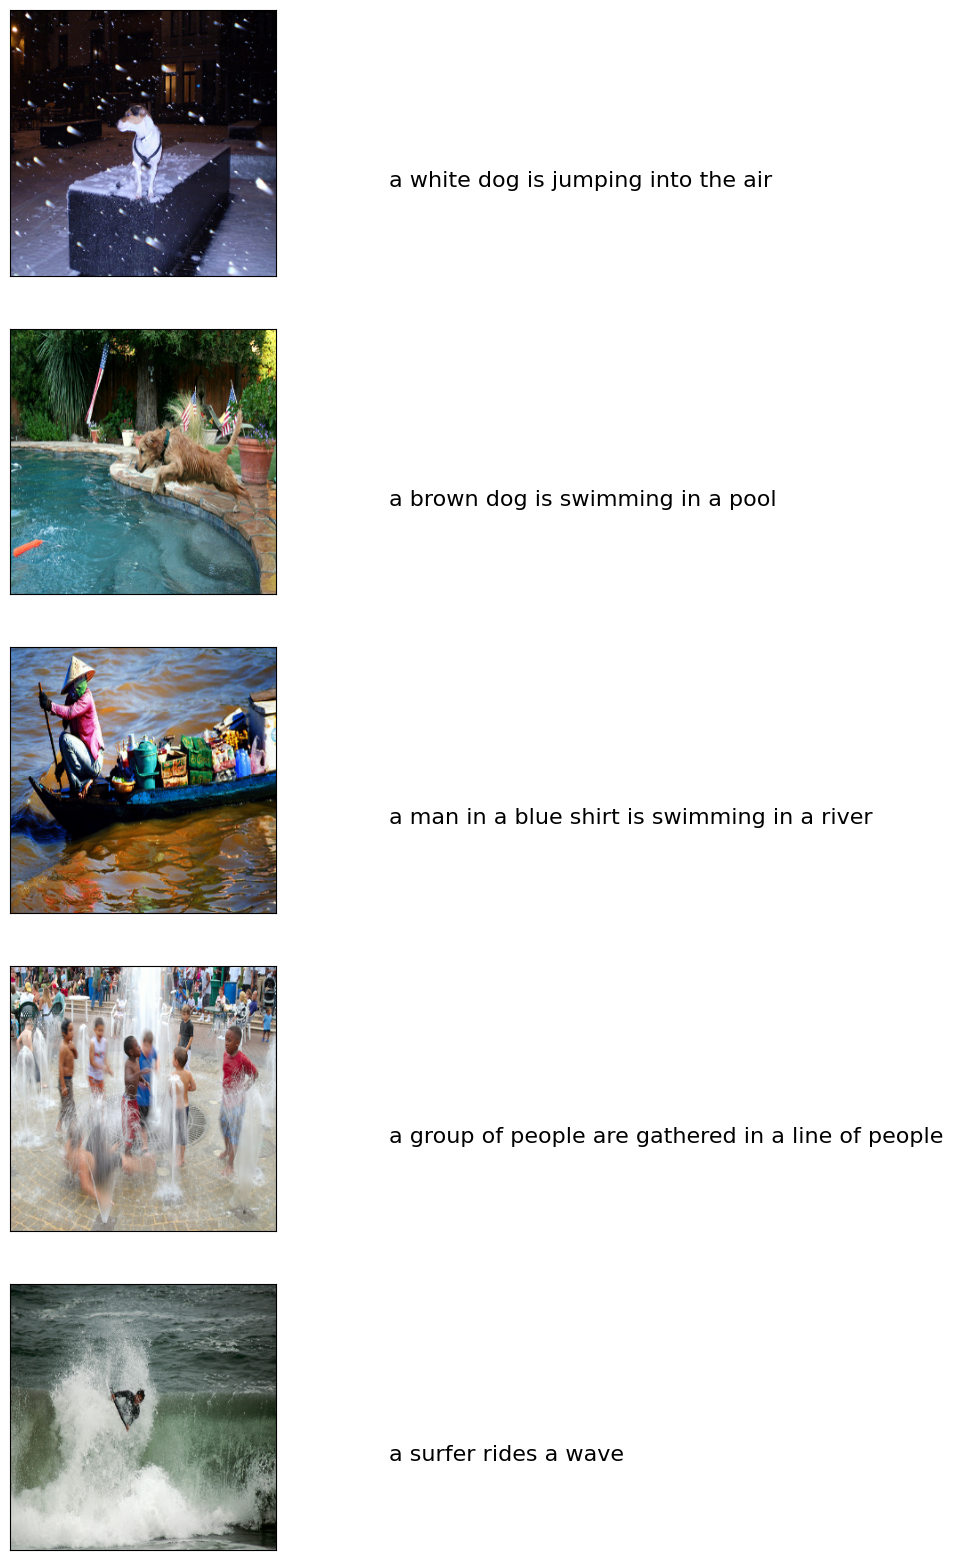

In [34]:
vocab = vectorization.get_vocabulary()
index_lookup = dict(zip(range(len(vocab)), vocab))
max_decoded_sentence_length = SEQ_LENGTH - 1
valid_images = list(valid_data.keys())

fig = plt.figure(figsize=(10,20))
count=1
npic = 5

for i in range(npic):
    # Select a random image from the validation dataset
    sample_img = np.random.choice(valid_images)

    # Read the image from the disk
    sample_img = decode_and_resize(sample_img)
    img = sample_img.numpy().clip(0, 255).astype(np.uint8)

    ax = fig.add_subplot(npic, 2, count, xticks=[], yticks=[])
    ax.imshow(img)
    count += 1

    ax = fig.add_subplot(npic, 2 , count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0,1)

    # Pass the image to the CNN
    img = tf.expand_dims(sample_img, 0)
    img = caption_model.cnn_model(img)

    # Pass the image features to the Transformer encoder
    encoded_img = caption_model.encoder(img, training=False)

    # Generate the caption using the Transformer decoder
    decoded_caption = "<start> "
    for i in range(max_decoded_sentence_length):
        tokenized_caption = vectorization([decoded_caption])[:, :-1]
        mask = tf.math.not_equal(tokenized_caption, 0)
        predictions = caption_model.decoder(
            tokenized_caption, encoded_img, training=False, mask=mask
        )
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = index_lookup[sampled_token_index]
        if sampled_token == "<end>":
            break
        decoded_caption += " " + sampled_token

    decoded_caption = decoded_caption.replace("<start> ", "")  # remove special tokens
    decoded_caption = decoded_caption.replace(" <end>", "").strip()
    ax.set_ylim(0, 3)
    ax.text(0, 1, decoded_caption, fontsize=16)
    count += 1

In [16]:
caption_model.save_weights('model_weights.h5')

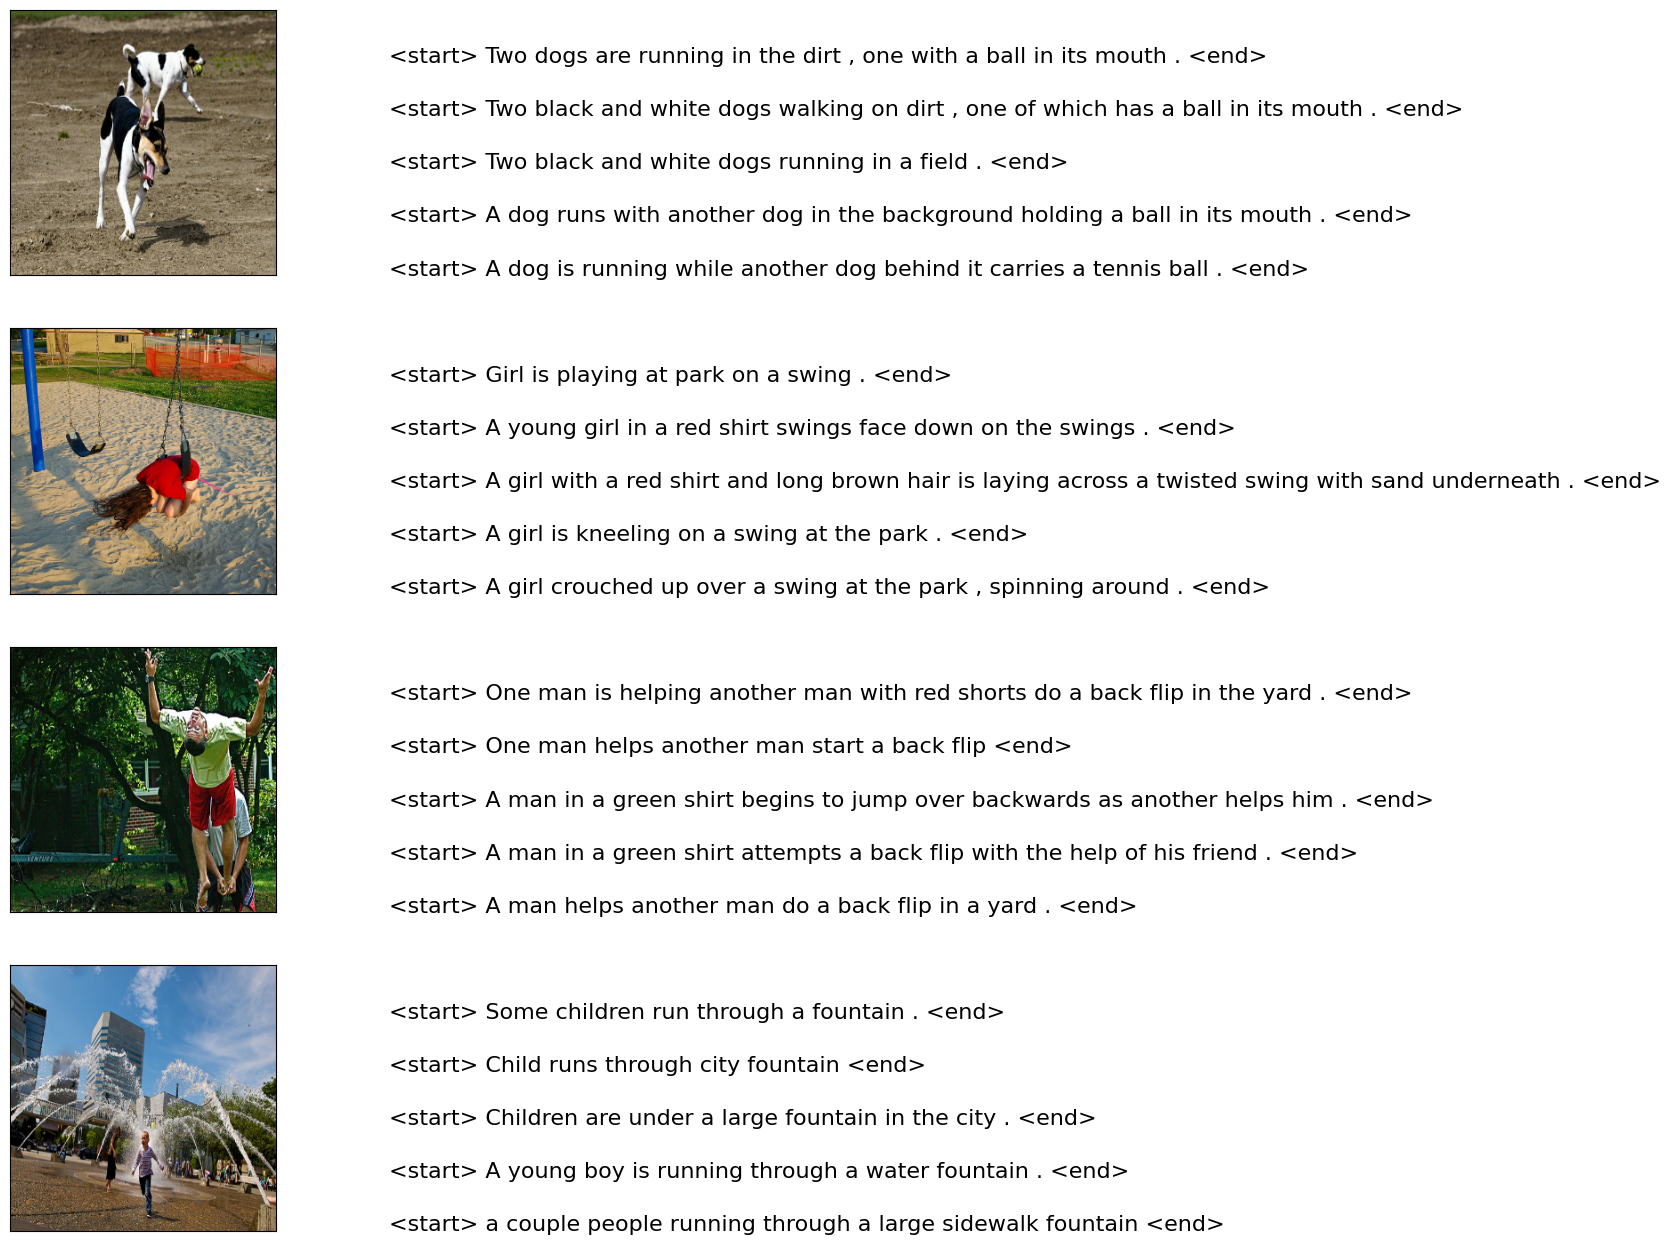

In [28]:
npic=5
count = 1
fig = plt.figure(figsize=(10,20))

for i in range(npic):
    sample_img = np.random.choice(valid_images)
    captions = valid_data[sample_img]

    sample_img = decode_and_resize(sample_img)
    img = sample_img.numpy().clip(0, 255).astype(np.uint8)

    ax = fig.add_subplot(npic, 2, count, xticks=[], yticks=[])
    ax.imshow(img)
    count += 1

    ax = fig.add_subplot(npic, 2 , count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0,1)
    ax.set_ylim(0, len(captions))
    for i, caption in enumerate(captions):
        ax.text(0, i, caption, fontsize=16)
    count += 1